In [35]:
import fastai
import torch
import numpy

In [36]:
from fastai.vision import *
import torch.nn.functional as F
from fastai.layers import *

In [37]:
transforms = get_transforms(do_flip=False, max_rotate=5.0, max_zoom=1.0,
    max_warp=0.0) # Todo look at these
DATA_PATH = "C:/Code/Senior Project"
data = ImageItemList.from_csv(DATA_PATH, "labels.csv")

In [38]:
data = (data.random_split_by_pct()
            .label_from_df(cols=["throttle", "direction"],  label_cls=FloatList)
            .transform(transforms, size=224)
            .databunch())

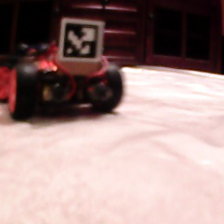

In [40]:
val_ds = data.valid_ds
img, label = val_ds[2]
img

In [10]:
reg_head = torch.nn.Sequential(Flatten(), torch.nn.Linear(86528, 2), SigmoidRange(-1, 1))
learn = create_cnn(data, models.squeezenet1_1, metrics=[], custom_head=reg_head, loss_func=F.mse_loss)

C:\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [12]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList
y: FloatList (2531 items)
[FloatItem [0. 0.], FloatItem [0. 0.], FloatItem [0. 0.], FloatItem [1. 0.], FloatItem [1. 0.]]...
Path: C:\Code\Senior Project
x: ImageItemList (2531 items)
[Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320)]...
Path: C:\Code\Senior Project;

Valid: LabelList
y: FloatList (632 items)
[FloatItem [1. 0.], FloatItem [0. 0.], FloatItem [0. 0.], FloatItem [0. 0.], FloatItem [0. 0.]]...
Path: C:\Code\Senior Project
x: ImageItemList (632 items)
[Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320)]...
Path: C:\Code\Senior Project;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
  

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


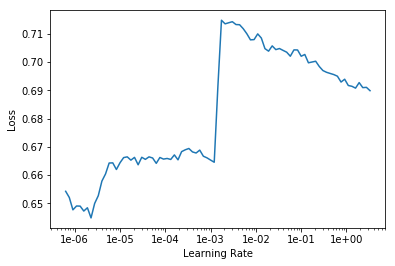

In [23]:
learn.recorder.plot()

In [15]:
epochs = 5
lr = 1e-3 # chosen using lr plot 
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss
1,0.673813,0.674994
2,0.678467,0.692528
3,0.672937,0.678462
4,0.672245,0.678418
5,0.670568,0.677739


In [28]:
learn.save("supervised", with_opt=False)

In [20]:
learn.load("supervised");

In [21]:
learn.unfreeze()

In [24]:
epochs = 3
lr = 1e-6 # lower on unfreeze
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss
1,0.667536,0.679247
2,0.666737,0.678281
3,0.672882,0.678977


In [19]:
learn.save("supervised", with_opt=False)

In [25]:
learn.predict(img)

(FloatItem [ 1. -1.], tensor([ 1., -1.]), tensor([ 1., -1.]))

In [26]:
print(label)

[0. 0.]


In [24]:
print(type(img))

<class 'fastai.vision.image.Image'>


In [27]:
learn.export()

In [51]:
# From fastai
def conv_bn_lrelu(ni:int, nf:int, ks:int=3, stride:int=1)->nn.Sequential:
    "Create a seuence Conv2d->BatchNorm2d->LeakyReLu layer."
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    "Resnet style layer with `ni` inputs."
    def __init__(self, ni:int):
        super().__init__()
        self.conv1=conv_bn_lrelu(ni, ni//2, ks=1)
        self.conv2=conv_bn_lrelu(ni//2, ni, ks=3)

    def forward(self, x): return x + self.conv2(self.conv1(x))

In [59]:
# From fastai, modified head
class CustomDarknet(nn.Module):
    "https://github.com/pjreddie/darknet"
    def make_group_layer(self, ch_in:int, num_blocks:int, stride:int=1):
        "starts with conv layer - `ch_in` channels in - then has `num_blocks` `ResLayer`"
        return [conv_bn_lrelu(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks:Collection[int], num_classes:int, nf=32):
        "create darknet with `nf` and `num_blocks` layers"
        super().__init__()
        layers = [conv_bn_lrelu(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        layers += [nn.Linear(num_classes, 2), SigmoidRange(-1, 1)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x): 
        return self.layers(x)

In [60]:
m = CustomDarknet([1, 2, 1], num_classes=10, nf=16)

In [61]:
m.load_state_dict(torch
                  .load("C:/Code/Senior Project/CapstoneRobot/src/Train/datasets/models/darknet_cifar.pth"), 
                  strict=False)

In [62]:
learn = Learner(data, m)
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (2531 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[0. 0.],[0. 0.],[0. 0.],[1. 0.],[1. 0.]
Path: C:\Code\Senior Project;

Valid: LabelList (632 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
[1. 0.],[0. 0.],[1. 0.],[0. 0.],[0. 0.]
Path: C:\Code\Senior Project;

Test: None, model=CustomDarknet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03


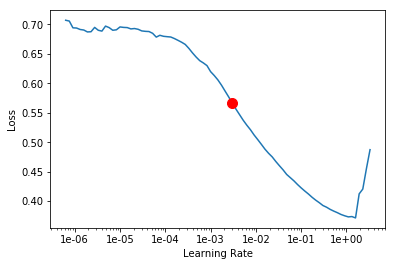

In [64]:
learn.recorder.plot()

In [65]:
epochs = 5
lr = 3e-3 # chosen using lr plot 
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss
1,0.336709,0.510885
2,0.225402,0.202715
3,0.186130,0.276650
4,0.167797,0.193377
5,0.156262,0.140060


In [71]:
learn.export()

C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CustomDarknet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ResLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
learn.save('supervised', with_opt=False)

In [ ]:
learn = load_learner()